# Risk Parity in ETF


[*********************100%***********************]  2 of 2 completed
C:\Users\Mike\AppData\Local\Temp\ipykernel_25316\397233361.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_prices = data.resample(rebalance_freq).last().dropna()
C:\Users\Mike\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\Mike\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Mike\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWar

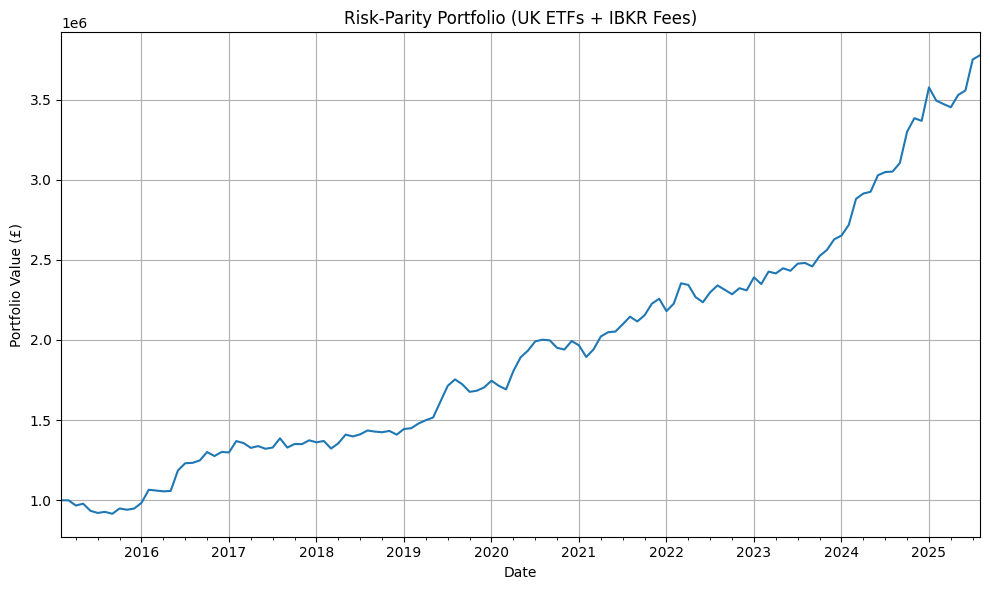

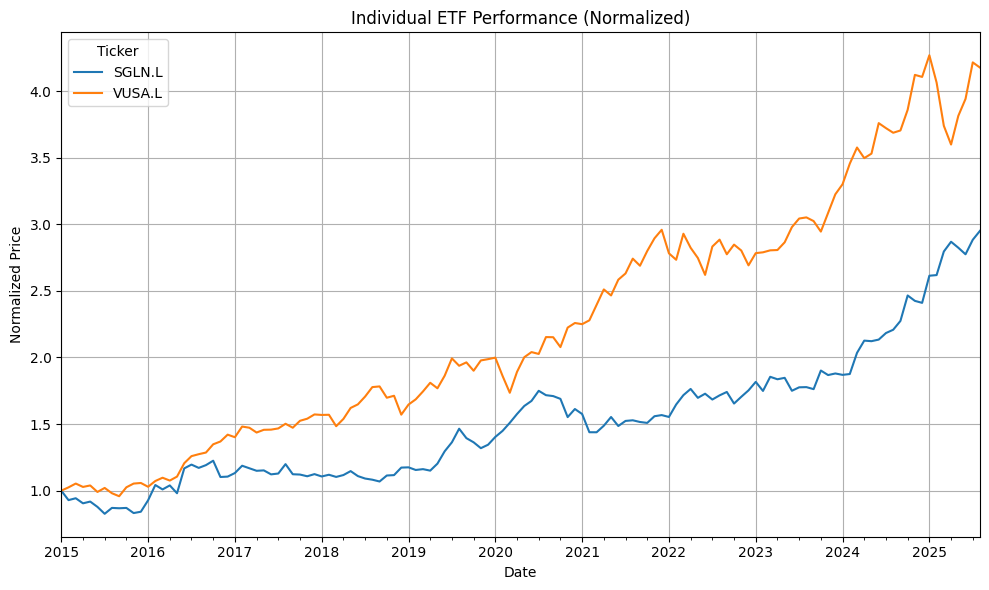

Final Portfolio Weights:
SGLN.L    0.5
VUSA.L    0.5
dtype: float64


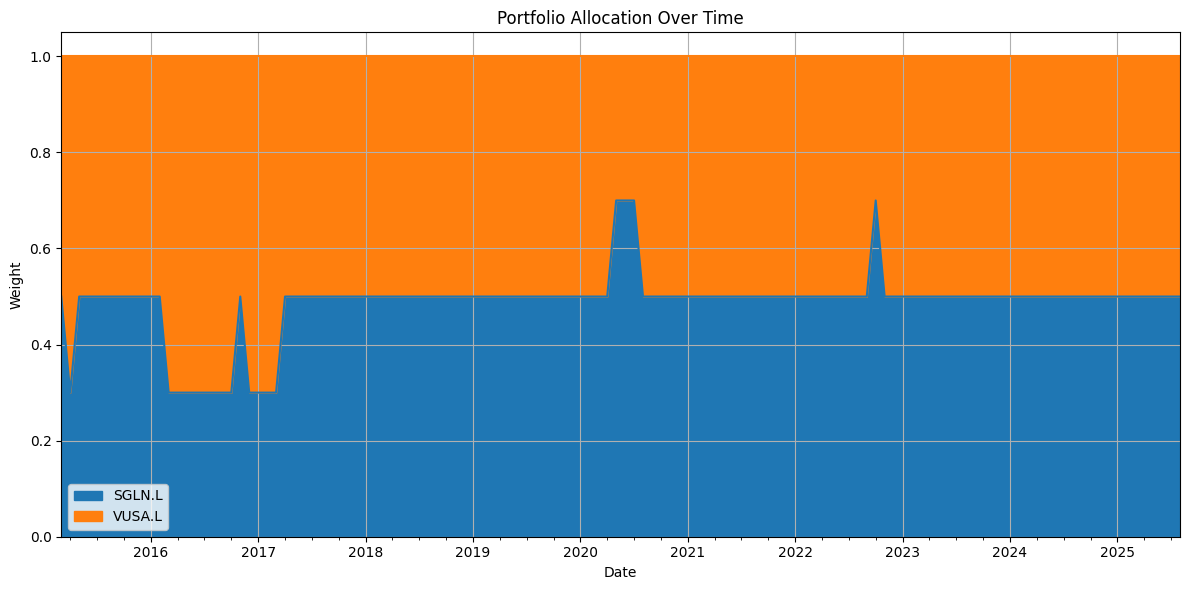


Average Monthly Return Matrix (%):
Month   Jan   Feb   Mar   Apr   May    Jun   Jul   Aug   Sep   Oct   Nov   Dec
Year                                                                          
2015    NaN   NaN -0.05 -3.24  1.17  -4.52 -1.43  0.73 -1.30  3.64 -0.85  0.81
2016   3.75  8.29 -0.47 -0.46  0.24  12.08  3.80  0.19  1.22  4.19 -1.92  1.99
2017  -0.22  5.45 -0.90 -2.22  0.84  -1.25  0.59  4.32 -4.16  1.66 -0.06  1.76
2018  -0.90  0.62 -3.46  2.47  4.01  -0.80  0.95  1.69 -0.48 -0.28  0.57 -1.61
2019   2.49  0.35  2.03  1.38  1.14   6.52  6.09  2.35 -1.75 -2.72  0.42  1.23
2020   2.46 -1.81 -1.31  6.72  4.79   2.21  2.97  0.54 -0.22 -2.33 -0.53  2.73
2021  -1.36 -3.70  2.52  4.15  1.30   0.22  2.20  2.26 -1.39  1.83  3.35  1.39
2022  -3.44  2.14  5.71 -0.45 -3.25  -1.40  2.79  1.85 -1.16 -1.21  1.66 -0.57
2023   3.52 -1.76  3.30 -0.46  1.32  -0.64  1.82  0.18 -0.88  2.66  1.48  2.60
2024   0.90  2.50  5.99  1.14  0.39   3.52  0.65  0.10  1.73  6.30  2.57 -0.49
2025   6.21 -2.3

C:\Users\Mike\AppData\Local\Temp\ipykernel_25316\397233361.py:131: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = portfolio_series.resample('M').last().pct_change().dropna()


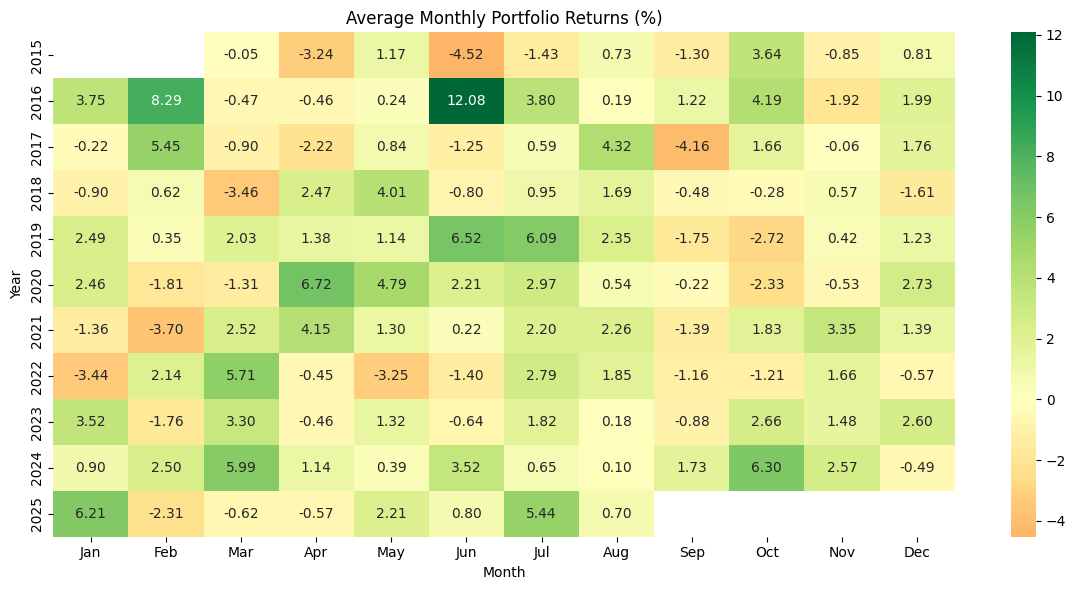


Annual Performance (%):
      Return
Date        
2016   37.21
2017    5.58
2018    2.58
2019   20.91
2020   16.99
2021   13.24
2022    2.31
2023   13.77
2024   28.13
2025   12.16


C:\Users\Mike\AppData\Local\Temp\ipykernel_25316\397233361.py:159: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = portfolio_series.resample('Y').last().pct_change().dropna()


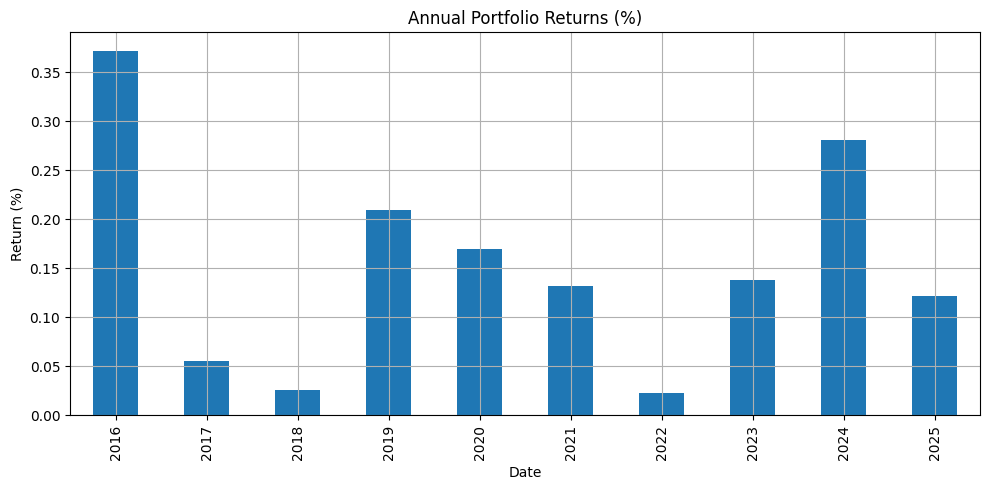

Performance Summary:
Sharpe Ratio (weekly): 0.41
Sharpe Ratio (annualized): 2.95
Cumulative Return: 277.66%
CAGR: 13.48%
Max Drawdown: -8.45%
Win Rate: 63.49%
Total IBKR Fees Paid: £3,632.19

Final Portfolio Weights:
SGLN.L    50.00%
VUSA.L    50.00%
dtype: object


In [ ]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#Asset Class	Ticker (LSE)	Description
#UK Equities	ISF.L	iShares Core FTSE 100 UCITS ETF
#Global Equities	VWRL.L	Vanguard FTSE All-World UCITS ETF
#Bonds (UK)	IGLT.L	iShares UK Gilts 0-5yr ETF
#Gold	SGLN.L	iShares Physical Gold ETC
#Inflation-linked	INXG.L	iShares GBP Index-Linked Gilts
#Property	IUKP.L	iShares UK Property UCITS ETF

# --- Configuration ---
tickers = ["SGLN.L","VUSA.L"]
#tickers = ["TQQQ", "SVXY", "VXZ", "TMF", "EDZ", "UGL"]
start_date = "2015-01-01"
end_date = "2025-08-31"
initial_capital = 1000000.0
max_weight = 0.70
rebalance_freq = "M"  # Monthly rebalancing


def calculate_ibkr_fee(trade_value):
    return max(6.00, 0.0005 * trade_value)

data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.dropna()


weekly_prices = data.resample(rebalance_freq).last().dropna()
weekly_returns = weekly_prices.pct_change().dropna()


def optimize_risk_parity(returns_window):
    cov = returns_window.cov().values
    n = len(cov)
    x0 = np.ones(n) / n
    bounds = [(0, max_weight)] * n
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    result = minimize(lambda w: 0.5 * w.T @ cov @ w, x0, bounds=bounds, constraints=constraints)
    return result.x if result.success else np.ones(n) / n

portfolio_value = [initial_capital]
weights_record = []
current_weights = np.zeros(len(tickers))
dates = weekly_returns.index
total_fees_paid = 0.0

for i in range(1, len(dates)):
    date = dates[i]
    prev_date = dates[i - 1]

    returns_window = weekly_returns.iloc[max(0, i - 4):i]
    weights = optimize_risk_parity(returns_window)

    prev_val = portfolio_value[-1]
    prev_prices = weekly_prices.loc[prev_date].values
    curr_prices = weekly_prices.loc[date].values

    current_allocation_value = current_weights * prev_val
    target_allocation_value = weights * prev_val


    trade_values = np.abs(target_allocation_value - current_allocation_value)
    trade_fees = [calculate_ibkr_fee(tv) if tv > 0 else 0.0 for tv in trade_values]
    total_trade_fee = np.sum(trade_fees)
    total_fees_paid += total_trade_fee


    ret = np.dot(weekly_returns.iloc[i], current_weights)
    new_val = prev_val * (1 + ret) - total_trade_fee

    portfolio_value.append(new_val)
    current_weights = weights
    weights_record.append(weights)


portfolio_series = pd.Series(portfolio_value, index=dates)
portfolio_series.plot(title='Risk-Parity Portfolio (UK ETFs + IBKR Fees)', figsize=(10, 6))
plt.ylabel("Portfolio Value (£)")
plt.grid(True)
plt.tight_layout()
plt.show()


normalized_prices = weekly_prices / weekly_prices.iloc[0]

normalized_prices.plot(figsize=(10, 6), title="Individual ETF Performance (Normalized)")
plt.ylabel("Normalized Price")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

final_weights = pd.Series(current_weights, index=tickers)
print("Final Portfolio Weights:")
print(final_weights)

weights_df = pd.DataFrame(weights_record, index=dates[1:], columns=tickers)
weights_df.plot.area(title="Portfolio Allocation Over Time", figsize=(12, 6), stacked=True)
plt.ylabel("Weight")
plt.grid(True)
plt.tight_layout()
plt.show()


returns = portfolio_series.pct_change().dropna()
weekly_sharpe = returns.mean() / returns.std()
annual_sharpe = weekly_sharpe * np.sqrt(52)

cumulative_return = portfolio_series.iloc[-1] / portfolio_series.iloc[0] - 1
rolling_max = portfolio_series.cummax()
drawdown = (portfolio_series - rolling_max) / rolling_max
max_drawdown = drawdown.min()
win_rate = (returns > 0).mean()


total_days = (portfolio_series.index[-1] - portfolio_series.index[0]).days
total_years = total_days / 365.25
cagr = (portfolio_series.iloc[-1] / portfolio_series.iloc[0]) ** (1 / total_years) - 1

monthly_returns = portfolio_series.resample('M').last().pct_change().dropna()
monthly_returns_df = monthly_returns.to_frame(name="Return")
monthly_returns_df["Year"] = monthly_returns_df.index.year
monthly_returns_df["Month"] = monthly_returns_df.index.strftime("%b")


pivot_table = monthly_returns_df.pivot_table(index="Year", columns="Month", values="Return")

month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
pivot_table = pivot_table[month_order]

print("\nAverage Monthly Return Matrix (%):")
print((pivot_table * 100).round(2))

import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table * 100, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("Average Monthly Portfolio Returns (%)")
plt.ylabel("Year")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

annual_returns = portfolio_series.resample('Y').last().pct_change().dropna()
annual_returns.index = annual_returns.index.year  # Use year as index

print("\nAnnual Performance (%):")
print((annual_returns * 100).round(2).to_frame(name="Return"))

annual_returns.plot(kind='bar', figsize=(10, 5), title="Annual Portfolio Returns (%)")
plt.ylabel("Return (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


print("Performance Summary:")
print(f"Sharpe Ratio (weekly): {weekly_sharpe:.2f}")
print(f"Sharpe Ratio (annualized): {annual_sharpe:.2f}")
print(f"Cumulative Return: {cumulative_return:.2%}")
print(f"CAGR: {cagr:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Total IBKR Fees Paid: £{total_fees_paid:,.2f}")
print("\nFinal Portfolio Weights:")
print(final_weights.sort_values(ascending=False).apply(lambda x: f"{x:.2%}"))

